# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [24]:
#Set current amount of BTC and ETH crypto assets
my_btc = 1.2 
my_eth = 5.3

In [25]:
#Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [26]:
btc_current_price = requests.get(btc_url).json() #Fetch current BTC price through python requests library
btc_current_price

eth_current_price = requests.get(eth_url).json()  #Fetch current ETH price through python requests library
eth_current_price

#Compute current value of my crpto
my_btc_value = btc_current_price['data']['1']['quotes']['USD']['price']  #Compute current value of btc
my_eth_value = eth_current_price['data']['1027']['quotes']['USD']['price']  #Compute current value of eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $23933.00
The current value of your 5.3 ETH is $1675.86


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [27]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [42]:
#Set Alpaca API key and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

#Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [29]:
#Format current date as ISO format
today = pd.Timestamp("2023-01-31", tz="America/New_York").isoformat()

#Set the tickers
tickers = ["AGG", "SPY"]

#Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

#Get current closing prices for SPY and AGG
df_tickers = alpaca.get_bars(
    tickers,
    timeframe,  #1-day closing prices
    start=today,
    end=today,
    limit=1000
).df  #format as dataframe

# Reorganize the DataFrame
AGG = df_tickers[df_tickers['symbol']=='AGG'].drop('symbol', axis=1)  #Separate ticker data
SPY = df_tickers[df_tickers['symbol']=='SPY'].drop('symbol', axis=1)

df_tickers = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])  #Concatenate the ticker DataFrames

df_tickers #Preview DataFrame


AGG                                    \
                             open    high     low   close    volume   
timestamp                                                             
2023-01-31 05:00:00+00:00  100.16  100.34  99.825  100.22  12083590   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2023-01-31 05:00:00+00:00       31977  100.037055  401.13  406.53  400.77   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2023-01-31 05:00:00+00:00  406.48  86809190      512600  404.158745

In [35]:
agg_close_price = float(df_tickers["AGG"]["close"])  #Pick AGG close price from the DataFrame
spy_close_price = float(df_tickers["SPY"]["close"])  #Pick SPY close price from the DataFrame

print(f"Current AGG closing price: ${agg_close_price}")  #Print AGG close price
print(f"Current SPY closing price: ${spy_close_price}")  #Print SPY close price

Current AGG closing price: $100.22
Current SPY closing price: $406.48


In [31]:
my_agg_value = my_agg * agg_close_price  #Compute the current value of AGG shares
my_spy_value = my_spy * spy_close_price  #Compute the current value of SPY shares

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $20324.00
The current value of your 200 AGG shares is $20044.00


### Savings Health Analysis

In [36]:
monthly_income = 12000 #Set monthly household income

#Consolidate financial assets data
crypto_assets = my_btc_value + my_eth_value  #Consolidate cryptocurrency assets
stock_bond_assets = my_agg_value + my_spy_value  #Consolidate stock & bond assets

#Set the data for the savings DataFrame
savings_data = {
    'Amount' : [crypto_assets, stock_bond_assets],
    'Assets' : ["Crypto", "Shares"]
}

df_savings = pd.DataFrame(savings_data).set_index('Assets')  #Create savings DataFrame

# Display savings DataFrame
display(df_savings)

,Amount
Assets,
Crypto,25608.86
Shares,40368.00


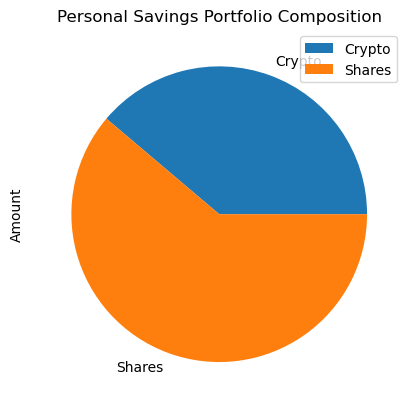

In [38]:
pie_chart = df_savings.plot.pie(y='Amount', title="Personal Savings Portfolio Composition")  #Plot savings pie chart


In [43]:
#Set ideal emergency fund
emergency_fund = monthly_income * 3

total_savings = df_savings['Amount'].sum()   #Calculate total amount of savings

#Validate saving health
if total_savings > emergency_fund:
    print(f"Congratulations! You have enough money in your emergency fund!")
elif total_savings == emergency_fund:
    print(f"Congratulations! You have reached your financial goal.")
else:
    print(f"You're ${emergency_fund - total_savings:0.2f} away from reaching your financial goal.")

Congratulations! You have enough money in your emergency fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [41]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2018-01-31', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-01-31', tz='America/New_York').isoformat()

In [49]:
#Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,  #1-day closing prices
    start=start_date,
    end=end_date,
    limit=10000  #limit to at least 10000 days
).df  #format as dataframe

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = df_stock_data[df_stock_data["symbol"]=="SPY"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])

# Display sample data
display(df_stock_data.head())

AGG                                     \
                             open     high     low   close    volume   
timestamp                                                              
2018-01-31 05:00:00+00:00  108.20  108.210  107.88  108.10   8066895   
2018-02-01 05:00:00+00:00  107.75  107.825  107.48  107.52  10330443   
2018-02-02 05:00:00+00:00  107.25  107.345  107.10  107.20   4779312   
2018-02-05 05:00:00+00:00  107.13  107.810  107.00  107.63   5991756   
2018-02-06 05:00:00+00:00  107.46  107.560  107.28  107.32   6031378   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2018-01-31 05:00:00+00:00       29280  108.033072  282.73  283.30  280.68   
2018-02-01 05:00:00+00:00       26477  107.695566  281.08  283.06  280.68   
2018-02-02 05:00:00+00:00       17781  107.197964  280.08  280.23  275.41   
2018-02-05 05:00:00+00:00       26360  107.347994  273.45  275.85  263.31   
2018-02-06 05:00:00+00:00       24296  107.432203  259.94  269.70  258.70   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2018-01-31 05:00:00+00:00  281.91  118954475      363005  281.967347  
2018-02-01 05:00:00+00:00  281.68   90622947      304909  281.766220  
2018-02-02 05:00:00+00:00  275.51  175825647      548623  277.434737  
2018-02-05 05:00:00+00:00  264.11  298863447     1178563  269.869953  
2018-02-06 05:00:00+00:00  269.06  354839027     1527398  264.957106

In [57]:
#Configuring a Monte Carlo simulation to forecast 30 years cumulative returns over 500 runs
MC_portfolio = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

# Print the simulation input data
MC_portfolio.portfolio_data.head()

AGG                                     \
                             open     high     low   close    volume   
timestamp                                                              
2018-01-31 05:00:00+00:00  108.20  108.210  107.88  108.10   8066895   
2018-02-01 05:00:00+00:00  107.75  107.825  107.48  107.52  10330443   
2018-02-02 05:00:00+00:00  107.25  107.345  107.10  107.20   4779312   
2018-02-05 05:00:00+00:00  107.13  107.810  107.00  107.63   5991756   
2018-02-06 05:00:00+00:00  107.46  107.560  107.28  107.32   6031378   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-01-31 05:00:00+00:00       29280  108.033072          NaN  282.73   
2018-02-01 05:00:00+00:00       26477  107.695566    -0.005365  281.08   
2018-02-02 05:00:00+00:00       17781  107.197964    -0.002976  280.08   
2018-02-05 05:00:00+00:00       26360  107.347994     0.004011  273.45   
2018-02-06 05:00:00+00:00       24296  107.432203    -0.002880  259.94   

                                                                          \
                             high     low   close     volume trade_count   
timestamp                                                                  
2018-01-31 05:00:00+00:00  283.30  280.68  281.91  118954475      363005   
2018-02-01 05:00:00+00:00  283.06  280.68  281.68   90622947      304909   
2018-02-02 05:00:00+00:00  280.23  275.41  275.51  175825647      548623   
2018-02-05 05:00:00+00:00  275.85  263.31  264.11  298863447     1178563   
2018-02-06 05:00:00+00:00  269.70  258.70  269.06  354839027     1527398   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-01-31 05:00:00+00:00  281.967347          NaN  
2018-02-01 05:00:00+00:00  281.766220    -0.000816  
2018-02-02 05:00:00+00:00  277.434737    -0.021904  
2018-02-05 05:00:00+00:00  269.869953    -0.041378  
2018-02-06 05:00:00+00:00  264.957106     0.018742

In [58]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/adeyemithomas/git/API-homework/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995509,0.992117,0.987501,1.015802,0.998959,1.004052,1.004147,0.986892,1.001500,0.995841,...,1.007599,1.032724,0.994428,1.001606,1.006679,1.000758,1.013626,0.994956,1.006639,0.975257
2,0.989019,0.996430,0.981537,1.023780,0.991134,1.011336,0.987355,1.000139,1.001410,0.997546,...,1.012610,1.039611,0.990584,1.000568,1.003353,1.001457,1.004378,1.003225,1.000073,0.978975
3,0.994552,1.001027,0.964201,1.022500,0.993080,1.009572,0.992592,0.998159,0.996018,1.003790,...,1.005159,1.048018,0.997446,0.998701,0.999968,1.009379,0.987361,0.991112,1.005482,0.973789
4,0.990162,1.003519,0.967038,1.031826,1.004367,1.009523,0.979073,0.991898,0.982166,1.008324,...,0.994150,1.060969,0.999007,1.004297,1.002400,1.009722,0.981594,1.007356,1.022138,0.977625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4.546898,2.563026,5.001694,6.051087,7.880941,7.712454,18.755884,3.704065,3.101925,0.978877,...,2.899075,7.869680,1.690763,4.612899,5.606004,4.172781,1.950615,6.557872,5.895427,17.477176
7557,4.535288,2.574166,5.037626,6.071020,7.771559,7.809723,18.665253,3.726097,3.067891,0.980406,...,2.851567,7.755197,1.706093,4.647156,5.687845,4.193365,1.922984,6.684593,5.939716,17.492090
7558,4.502689,2.571353,5.054378,6.011199,7.734300,7.726620,18.602334,3.744831,3.016582,0.975954,...,2.842872,7.775313,1.718521,4.659703,5.753751,4.182949,1.912240,6.654518,5.870861,17.390627
7559,4.442205,2.575880,5.044066,6.019664,7.701842,7.774650,18.447489,3.710931,2.983147,0.987694,...,2.836142,7.800157,1.722027,4.648221,5.735808,4.239225,1.923996,6.607410,5.797857,17.343511


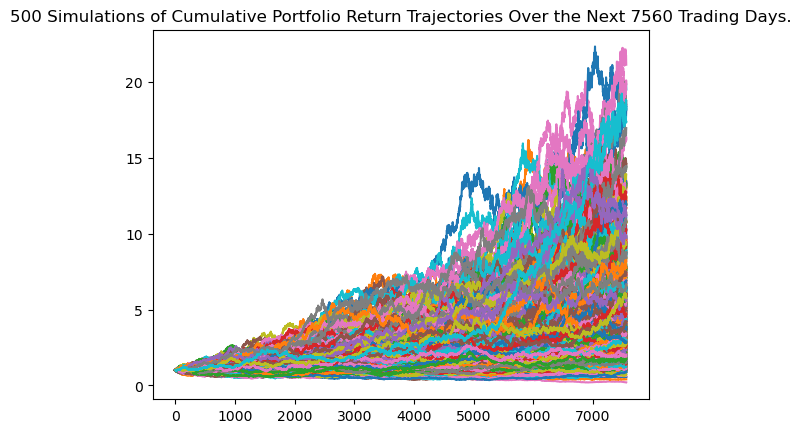

In [59]:
line_plot = MC_portfolio.plot_simulation()  #Plot simulation outcomes

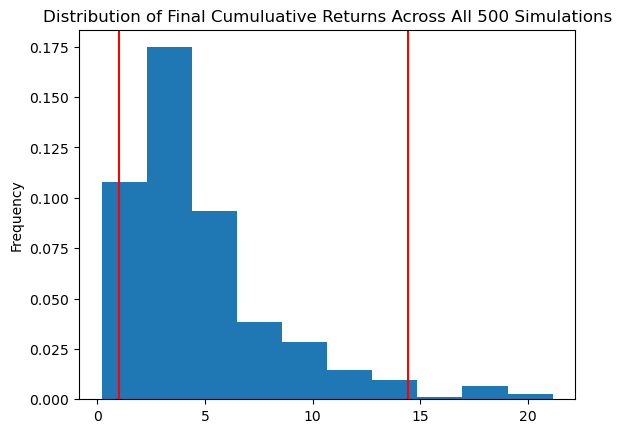

In [60]:
dist_plot = MC_portfolio.plot_distribution()   #Plot probability distribution and confidence intervals

### Retirement Analysis

In [61]:
summary_tbl = MC_portfolio.summarize_cumulative_return()  #Fetch summary statistics from the Monte Carlo simulation results

print(summary_tbl)  #Print summary statistics

count           500.000000
mean              4.798273
std               3.546746
min               0.205365
25%               2.406474
50%               3.843165
75%               6.057689
max              21.148793
95% CI Lower      0.988784
95% CI Upper     14.425854
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [62]:
initial_investment = 20000   #Set initial investment

#Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_tbl[8]*20000,2)
ci_upper = round(summary_tbl[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $19775.68 and $288517.08


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [65]:
initial_investment = 20000 * 1.5  #Set initial investment

#Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_tbl[8]*initial_investment,2)
ci_upper = round(summary_tbl[9]*initial_investment,2)

#Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $29663.53 and $432775.62


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001799,1.000245,1.006243,0.995742,1.003219,0.998395,0.997985,1.004253,1.002497,0.998947,...,1.007121,1.004291,1.000334,1.000876,0.998973,1.001375,0.996477,1.002103,1.005063,0.995521
2,0.998289,1.000243,1.004284,0.996554,1.004502,0.993317,0.996037,1.010316,1.000850,0.996382,...,1.007016,1.003709,0.999542,1.001450,1.004142,1.004022,0.996702,1.004359,1.009205,0.999000
3,1.002639,0.997279,1.008339,0.992870,0.998657,0.989041,0.994189,1.010062,0.999200,0.999132,...,1.004156,1.002288,1.003976,0.994908,1.008989,1.004545,0.995074,1.010488,1.011124,1.002626
4,1.008853,0.996292,1.002813,0.995244,0.996794,0.990576,0.999322,1.010897,0.989222,0.995257,...,1.000057,1.007349,1.006909,0.990823,1.013085,1.002427,0.996293,1.007081,1.010369,0.998654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.438618,0.926659,1.048662,1.101424,1.134443,1.200987,1.347489,1.257520,1.428939,1.194429,...,1.104654,1.273680,1.276718,1.297344,1.229379,1.295593,1.501864,1.198438,1.386161,1.426163
1257,1.441785,0.926428,1.048574,1.104941,1.137374,1.204559,1.360843,1.260661,1.429710,1.201055,...,1.107447,1.269262,1.265880,1.296800,1.227049,1.297884,1.510874,1.190802,1.388448,1.427391
1258,1.444675,0.931714,1.053040,1.110206,1.140592,1.199869,1.358605,1.254728,1.426409,1.207420,...,1.101690,1.274683,1.281527,1.303255,1.227517,1.294870,1.503567,1.191945,1.388434,1.441467
1259,1.443488,0.934065,1.049921,1.108998,1.142538,1.203844,1.363563,1.254192,1.425030,1.213366,...,1.103902,1.276629,1.275813,1.296929,1.222773,1.285521,1.498580,1.192940,1.397786,1.440244


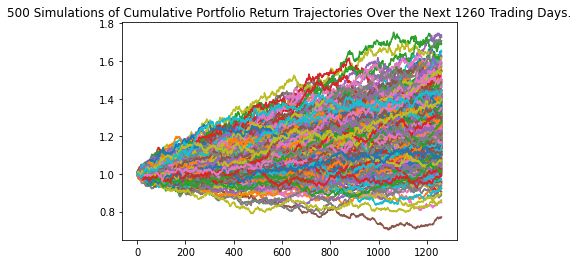

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

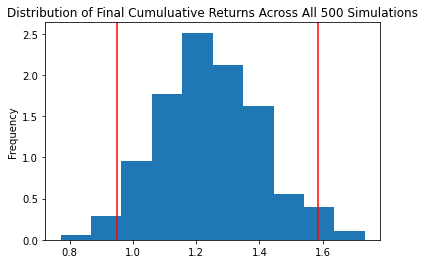

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.245905
std               0.160008
min               0.771559
25%               1.140795
50%               1.232555
75%               1.352284
max               1.733421
95% CI Lower      0.951523
95% CI Upper      1.586592
Name: 1260, dtype: float64


In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57091.37 and $95195.55


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004461,1.003269,0.998934,0.996767,1.000906,0.999279,0.995262,1.005752,0.993466,0.993655,...,1.001427,1.004350,0.996932,0.996844,0.997507,1.003457,0.998736,1.001195,0.999904,1.010218
2,1.007901,1.003304,0.993812,0.999973,1.000910,1.002347,0.996311,1.007234,0.993550,0.991021,...,0.997379,1.001952,0.998124,0.998063,1.001733,1.000273,0.994865,1.000109,0.994648,1.007838
3,1.007532,1.001077,0.990963,0.998339,1.001779,1.003653,0.994439,1.012230,0.999170,0.996484,...,0.995265,1.001745,0.995332,1.003023,1.003800,0.999755,0.997616,1.004730,0.993391,1.010444
4,1.020339,1.005743,0.991869,0.998218,1.005630,1.008717,0.987764,1.012750,0.999227,0.996474,...,0.999028,1.004730,0.995357,1.000204,1.008738,0.999273,0.999426,1.003776,0.991478,1.013379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.616922,1.761703,1.143430,1.687801,1.743826,1.174891,1.514199,2.447129,1.589765,1.570578,...,1.316494,1.863650,1.727959,1.411033,1.804671,1.500605,1.413278,1.552375,1.318340,1.960015
2517,1.620285,1.769184,1.145132,1.695693,1.742878,1.175745,1.517697,2.441471,1.586174,1.560826,...,1.318463,1.857860,1.724003,1.409092,1.810136,1.499466,1.413210,1.552539,1.316872,1.956776
2518,1.622141,1.771927,1.149019,1.691589,1.739420,1.178965,1.522624,2.444413,1.580680,1.566154,...,1.317147,1.864694,1.727503,1.419561,1.821212,1.492831,1.412283,1.556659,1.318842,1.961271
2519,1.628885,1.770207,1.149670,1.703935,1.738053,1.182429,1.519485,2.441360,1.565663,1.576607,...,1.307985,1.858986,1.728039,1.430017,1.814690,1.496851,1.409284,1.562660,1.324798,1.964190


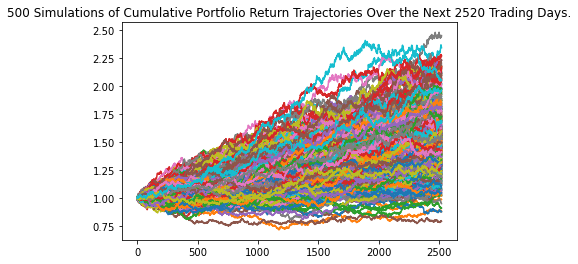

In [32]:
# Plot simulation outcomes
# YOUR CODE HERE!

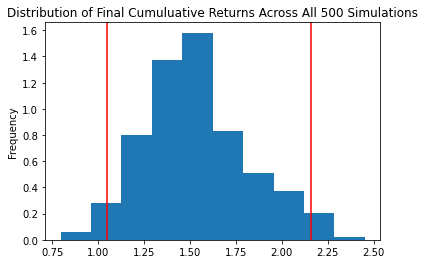

In [33]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [35]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
